In [1]:
from PIL import Image
from io import BytesIO

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from importlib import reload
from mpl_toolkits import mplot3d
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Image Detail

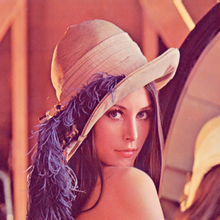

In [2]:
ori_img = Image.open("images/lena.png")
ori_img

In [3]:
X = np.array(ori_img.getdata())
pixels = X.reshape(*ori_img.size, -1)
pixels.shape

(220, 220, 3)

220 x 220 pixels, 3 channel RGB

In [4]:
len(set(ori_img.getdata()))

37270

37270 unique colors present in the image

In [5]:
def imageByteSize(img):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'png')
    return img_file.tell()/1024

imageByteSize(ori_img)

85.99609375

Original image size: 86KB

# 3D Visualization
plot first 100 pixels

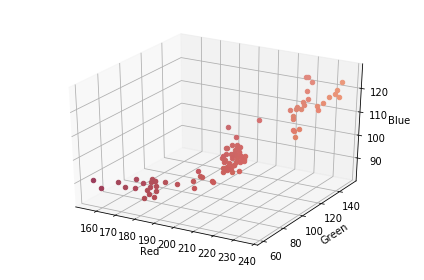

In [6]:
reload(plt)
fig = plt.figure("3-D Plot of Image")
ax = plt.axes(projection='3d')
for px in X[:100]:
    ax.scatter3D(*px, c = np.array([px])/255)
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
ax.dist = 11
plt.tight_layout()
plt.show()

# Kmeans Clustering
Try k=2, print the centroid

In [7]:
kmeans = KMeans(n_clusters = 2,
                n_jobs = -1,
                random_state = 123).fit(X)
pd.DataFrame(kmeans.cluster_centers_, columns = ['Red', 'Green', 'Blue'])

,Red,Green,Blue
0,130.542889,47.388621,77.450236
1,213.718313,133.891310,124.260309


replace each pixel value in a cluster with its centroid

In [8]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(*ori_img.size, -1)
    return new_pixels
new_pixels = replaceWithCentroid(kmeans)
new_pixels

array([[[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857]],

       [[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857]],

       [[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [130.54288939,  47.38862097,  77.45023599]],

       ...,

      

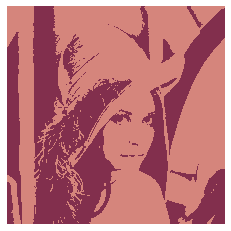

In [9]:
def plotImage(img_array, size):
    fig, ax = plt.subplots()
    ax.imshow(np.array(img_array).reshape(*size, 3))
    ax.axis('off')
    return plt
    
plotImage(new_pixels/255, ori_img.size).show()

In [10]:
imageByteSize(new_pixels)

4.3837890625

# Iterate

In [11]:
range_n_clusters = (2, 11)

kmeans_result = []
for n in range(*range_n_clusters):
    # clustering
    kmeans = KMeans(n_clusters = n,
                    n_jobs = -1,
                    random_state = 123).fit(X)
    
    # replace with centroid
    new_pixels = replaceWithCentroid(kmeans)
    
    metric = {
        "No. of Clusters": n,
        "Result": new_pixels,
        "No. of Iterations": kmeans.n_iter_,
        "WCSS": kmeans.inertia_,
        "Image Size (KB)": imageByteSize(new_pixels)
    }
    
    kmeans_result.append(metric)
kmeans_result = pd.DataFrame(kmeans_result).set_index("No. of Clusters")
kmeans_result

,Result,No. of Iterations,WCSS,Image Size (KB)
No. of Clusters,,,,
2,"[[[213.71831326970442, 133.89131036391043, 124...",9,1.092607e+08,4.383789
3,"[[[225.44421388667087, 167.00351157222383, 147...",6,6.079592e+07,6.662109
4,"[[[212.22476813966176, 122.26475722858449, 114...",5,3.829205e+07,8.654297
5,"[[[214.57149746804404, 134.9070010449294, 123....",11,2.953883e+07,10.584961
6,"[[[216.79463980880337, 136.00623079549067, 122...",23,2.440947e+07,11.326172
7,"[[[217.59388368070853, 137.3576954582662, 122....",14,2.088744e+07,13.569336
8,"[[[213.39740529319698, 128.35910742085883, 117...",16,1.829728e+07,15.281250
9,"[[[226.33964646464273, 156.76578282828027, 134...",18,1.623060e+07,16.035156
10,"[[[227.54112013324607, 143.86445971267722, 121...",30,1.467699e+07,17.332031


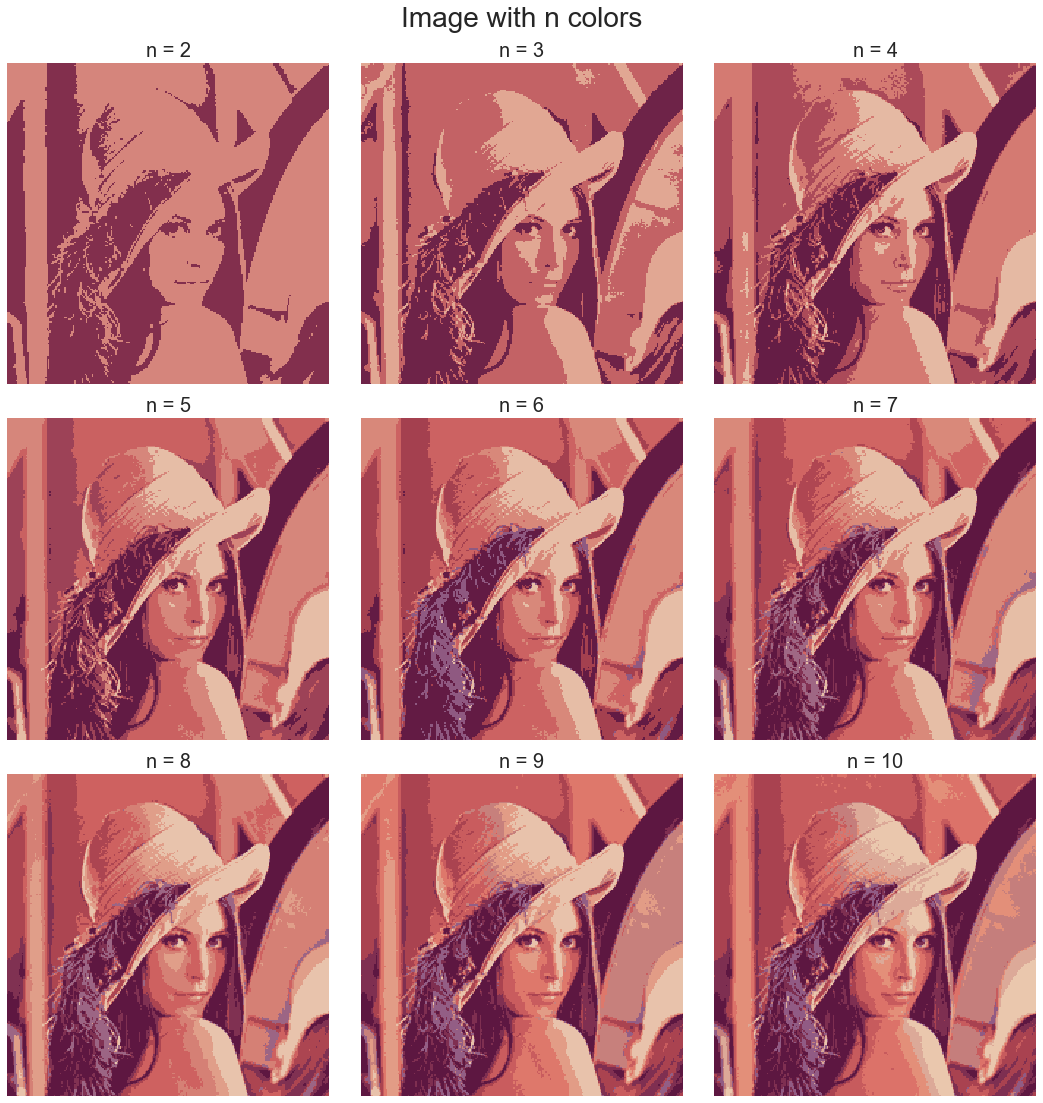

In [12]:
sns.set()
fig, axes = plt.subplots(3, 3, figsize=(15,15))
for ax, n_clusters, pixels in zip(axes.flat, kmeans_result.index, kmeans_result["Result"]):
    img_array = np.array(pixels)/255
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.axis("off")
    ax.set_title("n = {}".format(n_clusters), fontsize=20)
plt.tight_layout()
fig.suptitle("Image with n colors", size = 28, y = 1.02)
plt.show()

# Metric
- No. of kmeans iteration until it stabilize
- Within cluster sum of square (WCSS)
- Image size in KB

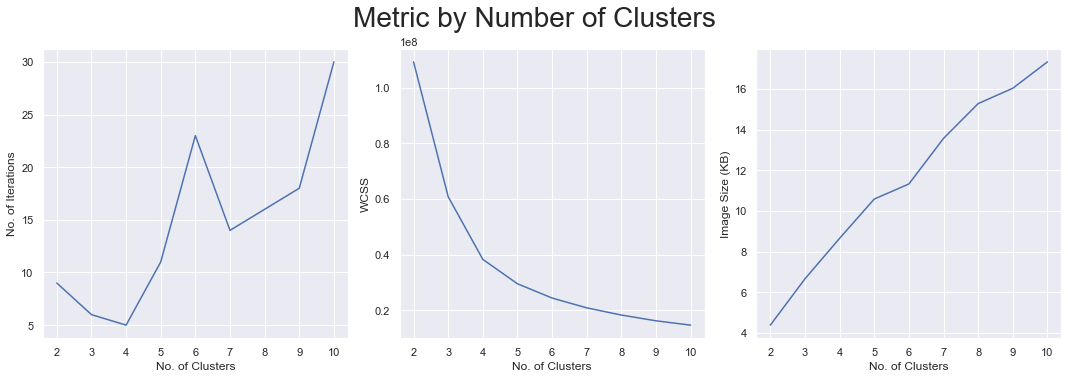

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, metric in zip(axes, kmeans_result.columns[1:]):
    sns.lineplot(x = kmeans_result.index, y = metric, data = kmeans_result, ax = ax)
plt.tight_layout()
fig.suptitle("Metric by Number of Clusters", size = 28, y = 1.05)
plt.show()

## Search for Optimal K (Elbow Method)
Use second derivative to get optimal K objectively (not by line plot only)

In [14]:
def calculateDerivative(data):
    derivative = []
    for i in range(len(data)):
        if i == 0:
            # forward difference
            d = data[i+1] - data[i]
        elif i == len(data) - 1:
            # backward difference
            d = data[i] - data[i-1]
        else:
            # center difference
            d = (data[i+1] - data[i-1])/2
        derivative.append(d)
    return np.array(derivative)

def searchOptimalElbow(data, range_n):
    start, end = range_n

    # Calculate First Derivative
    first_derivative = calculateDerivative(np.array(data))
    
    # Calculate Second Derivative
    second_derivative = calculateDerivative(first_derivative)

    # Find Opt K
    return np.argmax(np.abs(second_derivative)) + start

In [15]:
searchOptimalElbow(kmeans_result["No. of Iterations"], range_n_clusters)

6

In [16]:
n_opt_by_WCSS = searchOptimalElbow(kmeans_result["WCSS"], range_n_clusters)
n_opt_by_WCSS

3

In [17]:
n_opt_by_size = searchOptimalElbow(kmeans_result["Image Size (KB)"], range_n_clusters)
n_opt_by_size

8

In [18]:
ori_size = imageByteSize(ori_img)
opt_size = kmeans_result.loc[n_opt, "Image Size (KB)"]
print("Size Reduction: {}%".format(round((ori_size-opt_size)/ori_size * 100, 3)))

NameError: name 'n_opt' is not defined